### Loading Data

In [1]:
# Put all library imports and function definitions here
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
from statsmodels.stats.proportion import proportions_ztest
import random

In [2]:
antibiotics = ["Doxycycline", "Cefuroxime", "Ceftriaxone", "Azithromycin", "Amoxicillin", "Atovaquone", "Clindamycin"]
illnesses = ["Lyme", "Borrel", "Rickett", "Babesiosis", "Ehrlichiosis", "Rocky Mountain", "Anaplasmosis", "Southern Tick", "Relapsing Fever", "Tularemia", "Tick-Borne Viral Encephalitis", "Tick-Borne", "Colorado tick fever", "Q Fever"]

In [3]:
# df = pd.read_excel("./Data/" + antibiotics[0] + ".xlsx")
# for antibiotic in antibiotics[1:]:
#     df = pd.concat([df, pd.read_excel("./Data/" + antibiotic + ".xlsx")])
#     print(antibiotic)
# df = df.drop_duplicates()
# df_copy = df.copy(deep=True)
# df.to_pickle("saved_antibiotics_df")
df = pd.read_pickle("saved_antibiotics_df")

In [4]:
len(df)

149497

### Total Antibiotic Adverse Effects Summary Data

In [5]:
# Calculate total reported cases for each antibiotic
total_antibiotic_cases = []
for antibiotic in antibiotics:
    total_antibiotic_cases.append(df["Suspect Product Active Ingredients"].str.contains(antibiotic, case=False).sum())

print(antibiotics)
print(total_antibiotic_cases)

['Doxycycline', 'Cefuroxime', 'Ceftriaxone', 'Azithromycin', 'Amoxicillin', 'Atovaquone', 'Clindamycin']
[20266, 14527, 25756, 38993, 38421, 4018, 18800]


/tmp/ipykernel_75/610893795.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])


<Figure size 2400x1500 with 0 Axes>

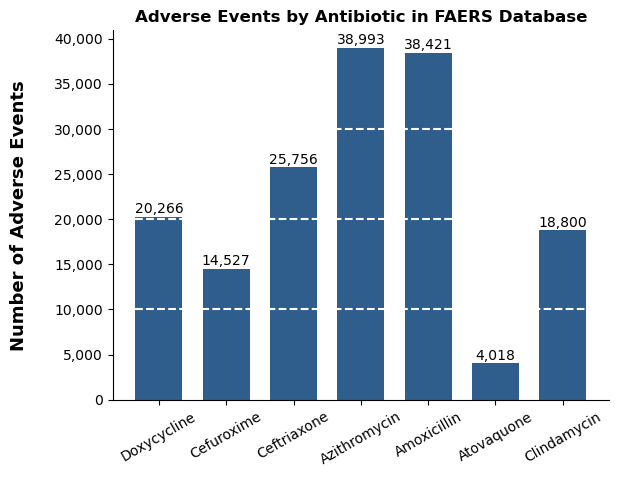

In [6]:
plt.figure(figsize=(8, 5), dpi=300)
fig, ax = plt.subplots()
# colors = ['#5fa8d3', '#0077b6', '#0096c7', '#00b4d8', '#48cae4', '#90e0ef', '#ade8f4']
# plt.pie(total_antibiotic_cases, labels=antibiotics, colors=colors, startangle=0, autopct='%1.1f%%')
plt.bar(antibiotics, total_antibiotic_cases, color='#2F5E8C', width=0.7)

for i in [10000, 20000, 30000]:
    plt.axhline(i, linestyle='--', color='white')

plt.xticks(rotation = 30)
plt.ylabel("Number of Adverse Events\n", fontsize=13, weight='bold')
plt.title("Adverse Events by Antibiotic in FAERS Database", weight='bold')

# put total above bars
# for i in range(len(total_antibiotic_cases)):
#     # total above the bars
#     plt.text(years_list[i], 102, 'n=' + str(sum(data_each_year[i])),
#          horizontalalignment='center', color='white',
#          fontsize=10)
    
for i, antibiotic in enumerate(total_antibiotic_cases):
    plt.text(i, total_antibiotic_cases[i] + 400, str(format(total_antibiotic_cases[i], ",")), horizontalalignment='center', fontsize=10)

    
# make y axis have commas
ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])
    
# get rid of top and right axis
ax.spines['top']. set_visible(False)
ax.spines['right']. set_visible(False)

plt.savefig("summary1.svg", bbox_inches='tight')
fig.show()

### Tick Total Antibiotic Adverse Effects Summary Data

In [7]:
# Calculate total reported cases for each antibiotic TICK specific
total_antibiotic_cases_tick = []
for antibiotic in antibiotics:
    df_tick_borne_reason = df[df['Reason for Use'].str.contains("|".join(illnesses), case=False)]
    total_antibiotic_cases_tick.append(df_tick_borne_reason["Suspect Product Active Ingredients"].str.contains(antibiotic, case=False).sum())

print(antibiotics)
print(total_antibiotic_cases_tick)

['Doxycycline', 'Cefuroxime', 'Ceftriaxone', 'Azithromycin', 'Amoxicillin', 'Atovaquone', 'Clindamycin']
[850, 81, 409, 268, 74, 203, 77]


<Figure size 2400x1500 with 0 Axes>

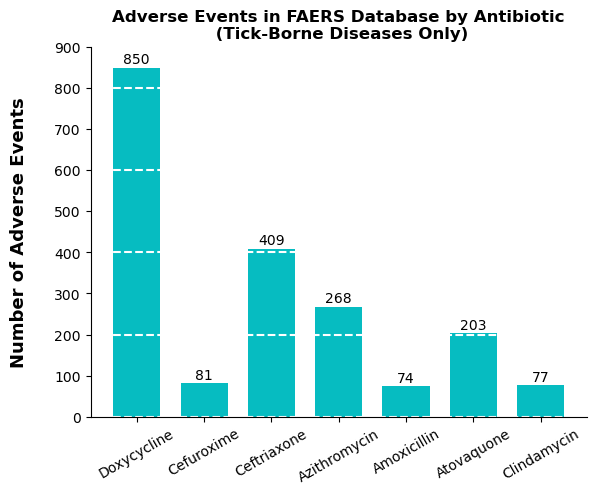

In [8]:
plt.figure(figsize=(8, 5), dpi=300)
fig, ax = plt.subplots()
plt.bar(antibiotics, total_antibiotic_cases_tick, color='#06BCC1', width=0.7)

for i in range(0, 1000, 200):
    plt.axhline(i, linestyle='--', color='white')

plt.xticks(rotation = 30)
plt.yticks([0, 100, 200, 300, 400, 500, 600, 700, 800, 900])
plt.ylabel("Number of Adverse Events\n", fontsize=13, weight='bold')
plt.title("Adverse Events in FAERS Database by Antibiotic\n (Tick-Borne Diseases Only)", weight='bold')
    
for i, antibiotic in enumerate(total_antibiotic_cases_tick):
    plt.text(i, total_antibiotic_cases_tick[i] + 10, str(format(total_antibiotic_cases_tick[i], ",")), horizontalalignment='center', fontsize=10)


# get rid of top and right axis
ax.spines['top']. set_visible(False)
ax.spines['right']. set_visible(False)

plt.savefig("summary2.svg", bbox_inches='tight')
fig.show()

### Total Treatment Severe Events vs. Tick Treatment Severe Events

In [9]:
percent_hospitalized_overall = []
percent_hospitalized_tick = []

sample_sizes_ntick = []
sample_sizes_tick = []

for antibiotic in antibiotics:
    # find percent of cases using doxy that result in hospitalization (excluding tick)
    df_specific_antibiotic = df[df["Suspect Product Active Ingredients"].str.contains(antibiotic, case=False)]
    # get rid of tick cases
    df_no_tick = df_specific_antibiotic[~df_specific_antibiotic['Reason for Use'].str.contains("|".join(illnesses), case=False)]
    total_reaction_count = len(df_no_tick)
    severe_count = df_no_tick['Outcomes'].str.contains("Hospitalized", case = False).sum()

    # find percent of tick cases using doxy that result in hospitalization
    df_only_tick = df_specific_antibiotic[df_specific_antibiotic['Reason for Use'].str.contains("|".join(illnesses), case=False)]
    total_reaction_count_tick = len(df_only_tick)
    severe_count_tick = df_only_tick['Outcomes'].str.contains("Hospitalized", case=False).sum()
    
    percent_hospitalized_overall.append(round(severe_count/total_reaction_count * 100, 2))
    percent_hospitalized_tick.append(round(severe_count_tick/total_reaction_count_tick * 100, 2))
    sample_sizes_ntick.append((severe_count, total_reaction_count))
    sample_sizes_tick.append((severe_count_tick, total_reaction_count_tick))
    # print("% cases resulting in hospitalization", round(severe_count/total_reaction_count * 100, 2))
    # print("% tick doxy cases resulting in hospitalization", round(severe_count_tick/total_reaction_count_tick * 100, 2))
    
for index, antibiotic in enumerate(antibiotics):
    print(antibiotic, percent_hospitalized_overall[index], percent_hospitalized_tick[index])

Doxycycline 25.67 28.0
Cefuroxime 34.82 20.99
Ceftriaxone 48.16 28.61
Azithromycin 27.97 23.88
Amoxicillin 41.12 39.19
Atovaquone 35.6 21.67
Clindamycin 29.77 36.36


In [10]:
list_pvals_per_antibiotic = []

print(sample_sizes_ntick)
print(sample_sizes_tick)

[(4984, 19416), (5030, 14446), (12206, 25347), (10831, 38725), (15767, 38347), (1358, 3815), (5573, 18723)]
[(238, 850), (17, 81), (117, 409), (64, 268), (29, 74), (44, 203), (28, 77)]


In [11]:
from scipy.stats import binomtest

#calculate binomial probability
k = 29
n = 74
p = 0.5

res = binomtest(k, n, p)
res.pvalue

0.08050685743008208

Left:  0.28 Right:  0.72 
Count:  0
P-val:  0.0


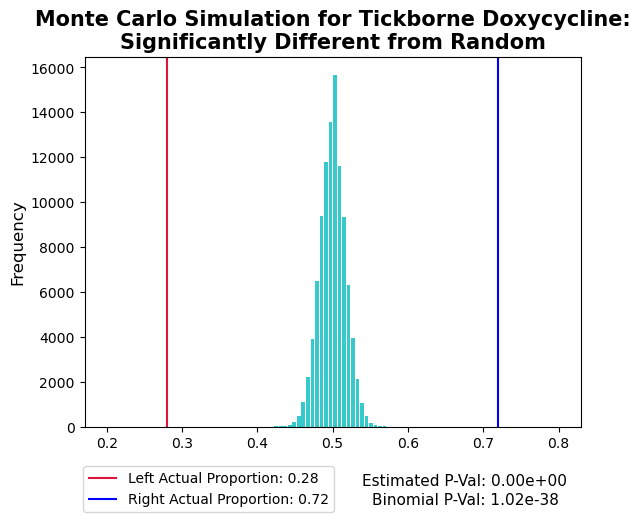

Left:  0.21 Right:  0.79 
Count:  0
P-val:  0.0


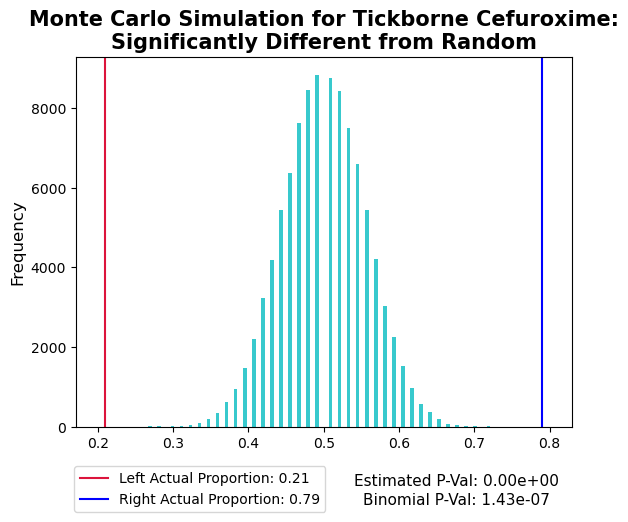

Left:  0.286 Right:  0.714 
Count:  0
P-val:  0.0


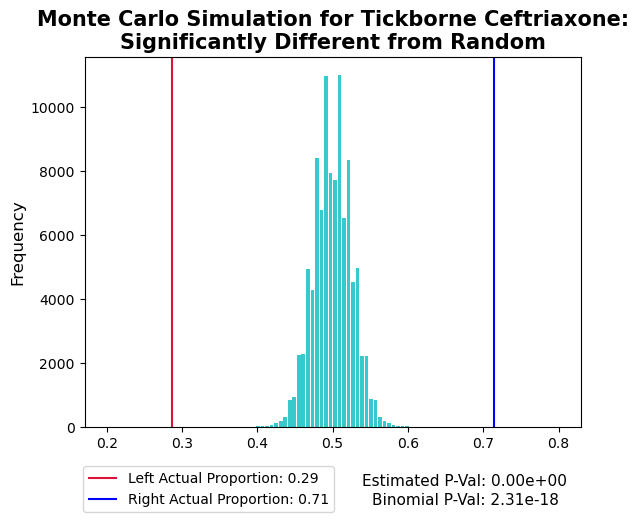

Left:  0.239 Right:  0.761 
Count:  0
P-val:  0.0


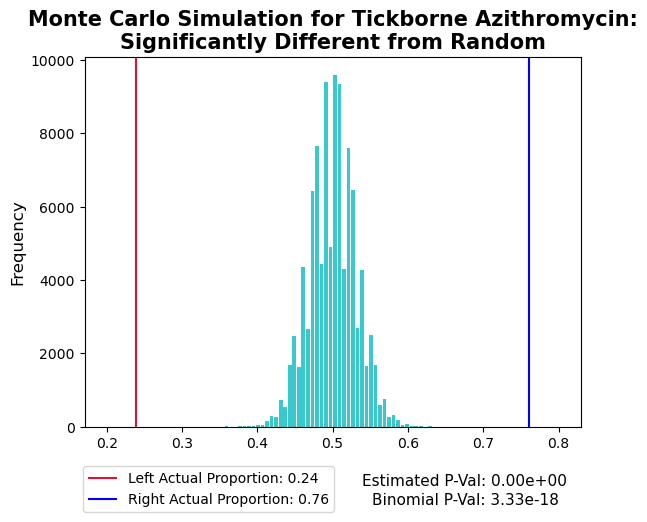

Left:  0.392 Right:  0.608 
Count:  8172
P-val:  0.08172


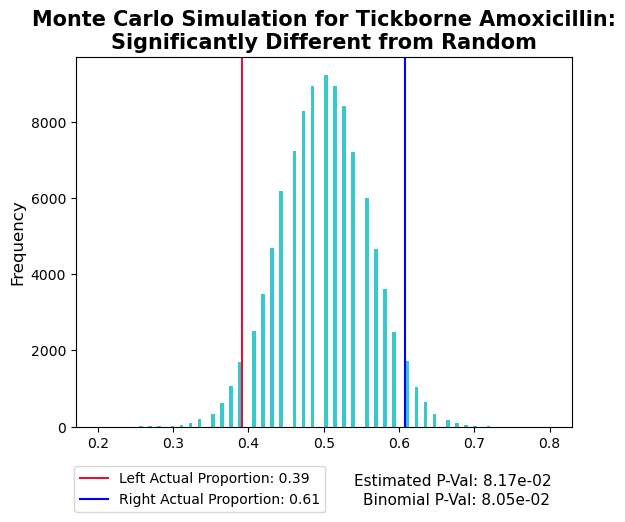

Left:  0.217 Right:  0.783 
Count:  0
P-val:  0.0


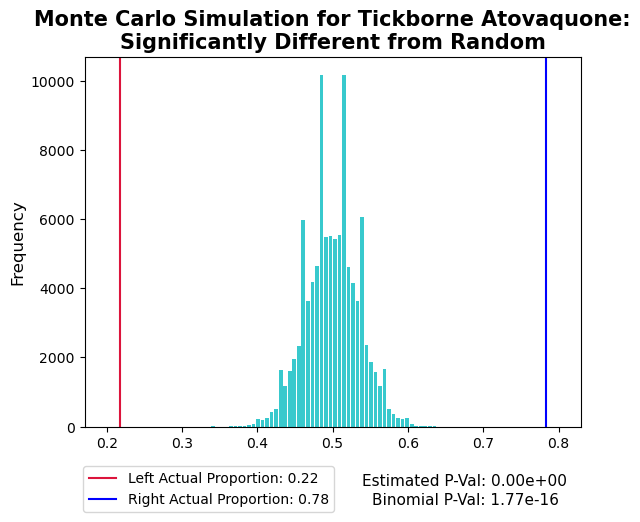

Left:  0.364 Right:  0.636 
Count:  2266
P-val:  0.02266


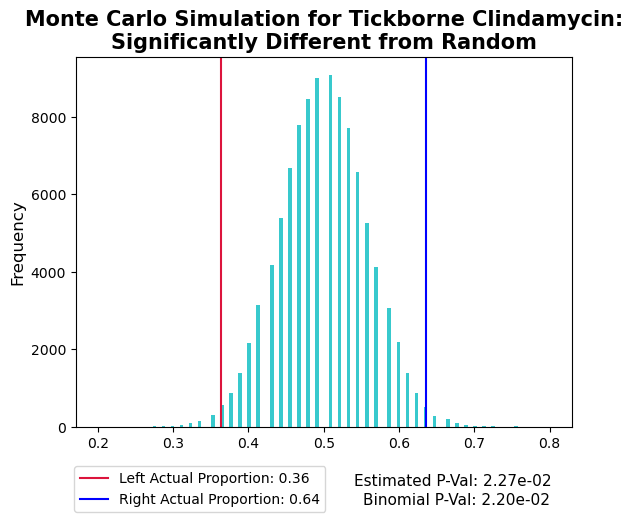

In [35]:
def monte_carlo_plus_freq(antibiotic, iterations):
    
    numerator = sample_sizes_tick[antibiotic][0]
    denominator = sample_sizes_tick[antibiotic][1]
    
    # makes a list with each element being the total number of times someone was hospitalized in the n samples, done samples times
    all_tests = [sum([random.randint(0,1) for i in range(denominator)])/denominator for j in range(iterations)]
    count = 0
    left_p = numerator/denominator
    right_p = 1-left_p
    for val in all_tests:
        # check if value percentage is above or below
        if ((val <= left_p) or (val >= right_p)):
            count += 1
    
    print("Left: ", round(left_p, 3), "Right: ", round(right_p, 3), "\nCount: ",count)
    print("P-val: ", round(count/iterations, 8))
    
    n, bins, patches = plt.hist(all_tests, bins=100, color='#06BCC1', alpha=0.8, rwidth=0.8, range=[0.2,0.8]) # range=[0,1]
    # plt.xlabel('Value', size=13, weight='bold')
    plt.ylabel('Frequency',size=12)
    # plt.title('Normal Estimation Frequency Histogram of ' + antibiotics[antibiotic] + "\n Tickborne Monte Carlo Simulation", size=15, weight='bold')
    # plt.title("Monte Carlo Simulation for Tickborne " + antibiotics[antibiotic] + ":\nNormal Estimation Frequency Histogram", size=15, weight='bold')
    plt.title("Monte Carlo Simulation for Tickborne " + antibiotics[antibiotic] + ":\nSignificantly Different from Random", size=15, weight='bold')
    
    plt.axvline(round(left_p, 3), color="crimson", label="Left Actual Proportion: "+str(round(left_p, 2)))
    # plt.legend([l], ["p={}".format(p)], loc=1)
    plt.axvline(round(right_p, 3), color="blue", label="Right Actual Proportion: "+str(round(right_p, 2)))
    plt.legend(bbox_to_anchor =(0.25,-0.25), loc='lower center')
    
    # plt.text(0.5, -1, 'Calculated P-Val: '+str(round(count/iterations, 3)), fontsize = 13)
    # plt.text(0.5, -150, 'Calculated P-Val: '+str(round(count/iterations, 3)), fontsize = 13)
    plt.annotate('Estimated P-Val: '+str("{:.2e}".format(count/iterations)), xy=(0.56, -0.16), xycoords='axes fraction', fontsize = 11)
    
    
    # calc binomial, default behavior is two-tailed
    result = binomtest(numerator, denominator, 0.5)
    binomial_p_val = result.pvalue
    
    plt.annotate('Binomial P-Val: '+str("{:.2e}".format(binomial_p_val)), xy=(0.58, -0.21), xycoords='axes fraction', fontsize = 11)
    
    plt.savefig('Graphs/histogram'+antibiotics[antibiotic]+".svg", bbox_inches='tight')
    plt.show()
    return all_tests

# x = monte_carlo_plus_freq(0, 1000)

for index, _ in enumerate(antibiotics):
    monte_carlo_plus_freq(index, 100000)

In [13]:
# https://www.socscistatistics.com/tests/ztest/default2.aspx
# https://sonalake.com/latest/hypothesis-testing-of-proportion-based-samples/

p_val_list = []

for i in range(len(sample_sizes_tick)):
    # the samples do not need to be the same size
    sample_success_a, sample_size_a = sample_sizes_ntick[i]
    sample_success_b, sample_size_b = sample_sizes_tick[i]

    # check our sample against Ho for Ha != Ho
    successes = np.array([sample_success_a, sample_success_b])
    samples = np.array([sample_size_a, sample_size_b])

    # note, no need for a Ho value here - it's derived from the other parameters
    stat, p_value = proportions_ztest(count=successes, nobs=samples,  alternative='two-sided')
    
    p_val_list.append(p_value)

p_val_list

[0.12836208795272466,
 0.009131192004334135,
 4.112843893155411e-15,
 0.13715125947706822,
 0.7363784644940528,
 5.0132100026874296e-05,
 0.20645883036295698]

In [14]:
antibiotics

['Doxycycline',
 'Cefuroxime',
 'Ceftriaxone',
 'Azithromycin',
 'Amoxicillin',
 'Atovaquone',
 'Clindamycin']

<Figure size 3200x1920 with 0 Axes>

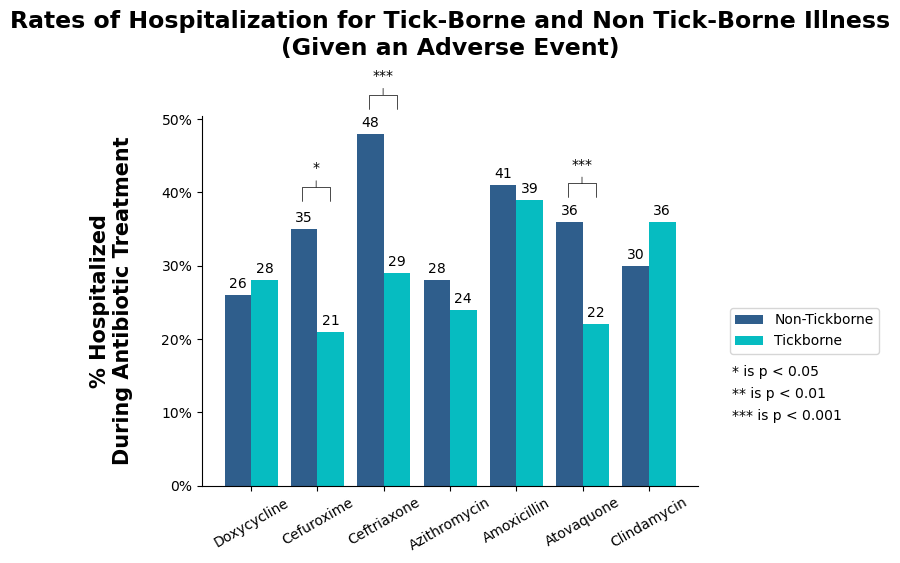

In [37]:
x = np.array([0, 2, 4, 6, 8, 10, 12])  # the label locations
width = 0.8 # the width of the bars

plt.figure(figsize=(8, 4.8), dpi=400)
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, [round(x) for x in percent_hospitalized_overall], width, label='Non-Tickborne', color="#2F5E8C")
rects2 = ax.bar(x + width/2, [round(x) for x in percent_hospitalized_tick], width, label='Tickborne', color="#06BCC1")

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('% Hospitalized\nDuring Antibiotic Treatment\n', size=15, weight='bold')
ax.set_title('Rates of Hospitalization for Tick-Borne and Non Tick-Borne Illness\n(Given an Adverse Event)\n\n', size=17, weight='bold')
ax.set_xticks(x, antibiotics, rotation=30)

# * is p < 0.05
# ** is p < 0.01
# *** is p < 0.001
ax.annotate('*', xy=(0.23, 0.8), xytext=(0.23, 0.84), xycoords='axes fraction', 
            fontsize=10, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=1, lengthB=1', lw=0.5))

ax.annotate('***', xy=(0.365, 1.05), xytext=(0.365, 1.09), xycoords='axes fraction', 
            fontsize=10, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=1, lengthB=1', lw=0.5))

ax.annotate('***', xy=(0.766, .81), xytext=(0.766, 0.85), xycoords='axes fraction', 
            fontsize=10, ha='center', va='bottom',
            arrowprops=dict(arrowstyle='-[, widthB=1, lengthB=1', lw=0.5))


plt.legend(bbox_to_anchor = [1.05, 0.5])

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.yaxis.set_major_formatter(mtick.PercentFormatter())

ax.text(14.5, 15, "* is p < 0.05")
ax.text(14.5, 12, "** is p < 0.01")
ax.text(14.5, 9, "*** is p < 0.001")

plt.savefig("adverse_comparison.svg", bbox_inches="tight")
plt.show()

### Tick Borne Disease Treatment Adverse Events Over Time

In [16]:
# get only tick cases
df_only_tick = df[df['Reason for Use'].str.contains("|".join(illnesses), case=False)]

# for every year since 2000
year_list_date = []
# for each of those years
year_tick_adverse_events = []

for year in range(1997, 2022):
    df_year = df_only_tick[df_only_tick["Initial FDA Received Date"].str.endswith(str(year))]
    year_tick_adverse_events.append(len(df_year))
    year_list_date.append(year)
    # print(year, len(df_year))

<Figure size 2400x1440 with 0 Axes>

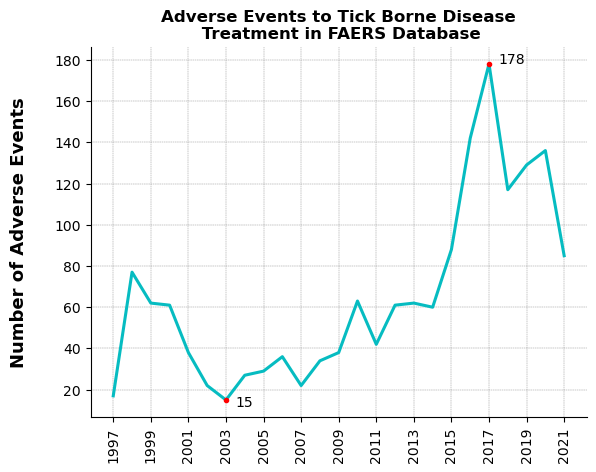

In [17]:
plt.figure(figsize=(8, 4.8), dpi=300)
fig, ax = plt.subplots()

plt.xticks([num for num in range(1997, 2022)])
plt.xticks(rotation = 90)
plt.ylabel("Number of Adverse Events\n", fontsize=13, weight='bold')
plt.title("Adverse Events to Tick Borne Disease\n Treatment in FAERS Database", weight='bold')

# get rid of top and right axis
ax.spines['top']. set_visible(False)
ax.spines['right']. set_visible(False)

plt.plot(year_list_date, year_tick_adverse_events, color='#06BCC1', linewidth=2.2)

graph_max = max(year_tick_adverse_events)
graph_min = min(year_tick_adverse_events)
plt.plot(2017, graph_max, marker=".", color='red')
plt.plot(2003, graph_min, marker=".", color='red')

plt.text(2017+0.5, graph_max+0.5, str(graph_max))
plt.text(2003+0.5, graph_min-3, str(graph_min))
plt.grid(linestyle = '--', linewidth = 0.3, color='grey')

ax.set_xticks(ax.get_xticks()[::2])
plt.savefig('events_over_time.svg', bbox_inches='tight')
plt.show()

### Word Cloud / NLP Imports

In [18]:
!pip install wordcloud
!pip install nltk

  Using cached wordcloud-1.8.2.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (458 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 36.3 MB/s eta 0:00:0000:01
  Using cached regex-2022.10.31-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (770 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 14.8 MB/s eta 0:00:00


In [19]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud as WC
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from PIL import Image
import string

### Word Cloud All Data

In [20]:
np.savetxt('ReactionsText.txt', df['Reactions'], fmt="%s")
file = open("ReactionsText.txt")
sw = file.read()
file.close()

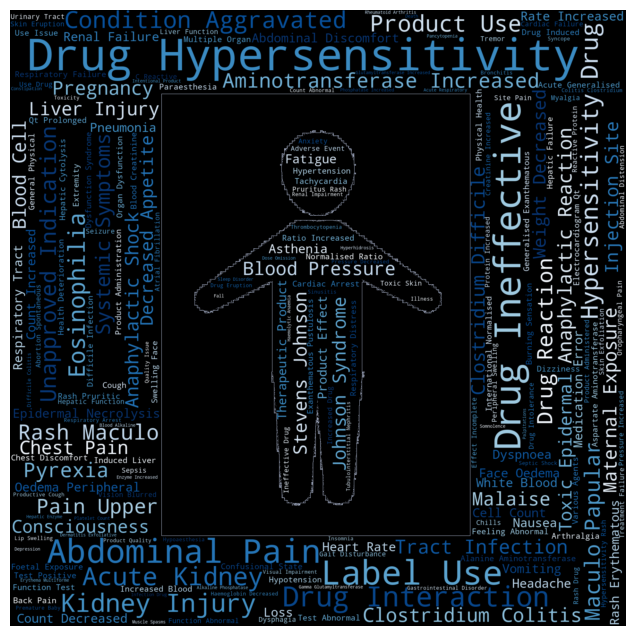

In [21]:
# wc = WC().generate(sw)
# plt.figure(figsize=(8,8))
# plt.imshow(wc)
# plt.axis('off')
# plt.show()
mask = np.array(Image.open('body2.jpeg'))

wc = WC(colormap="Blues", background_color='black', contour_color='#d2defc', contour_width=0.3, random_state=5, mask=mask, collocations=True).generate(sw)
plt.figure(figsize=(8,8))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.savefig("effects_wordcloud.svg", bbox_inches='tight')
plt.show()

In [22]:
# Process the text
# Part 1 - convert to a list of words
sw = sw.lower()
tokens = word_tokenize(sw)

stops = set(stopwords.words('english')).union({';', '...', "'s", "n't", "'re"})

# Part 2 - remove punctuation
tokens = [token for token in tokens if token not in stops]

fd = nltk.FreqDist(tokens)
fd.most_common(20)

[('drug', 32513),
 ('pain', 18850),
 ('increased', 18214),
 ('hypersensitivity', 17618),
 ('rash', 15501),
 ('disorder', 12162),
 ('infection', 11559),
 ('decreased', 11304),
 ('product', 11266),
 ('blood', 10849),
 ('use', 10310),
 ('diarrhoea', 9799),
 ('abdominal', 9440),
 ('ineffective', 8544),
 ('reaction', 8147),
 ('acute', 7984),
 ('pruritus', 7977),
 ('oedema', 7832),
 ('injury', 7571),
 ('abnormal', 7486)]

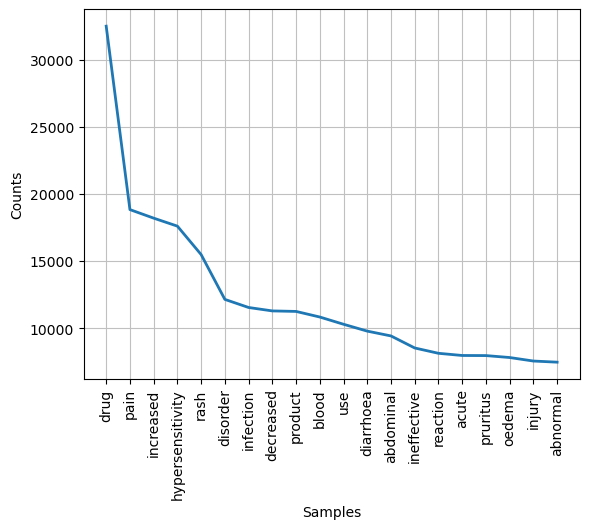

<AxesSubplot: xlabel='Samples', ylabel='Counts'>

In [23]:
fd.plot(20)

### Word Cloud Tickborne

In [24]:
df_tick_borne_reason = df[df['Reason for Use'].str.contains("|".join(illnesses), case=False)]

np.savetxt('ReactionsTextTick.txt', df_tick_borne_reason['Reactions'], fmt="%s")
filetick = open("ReactionsTextTick.txt")
swt = filetick.read()
filetick.close()

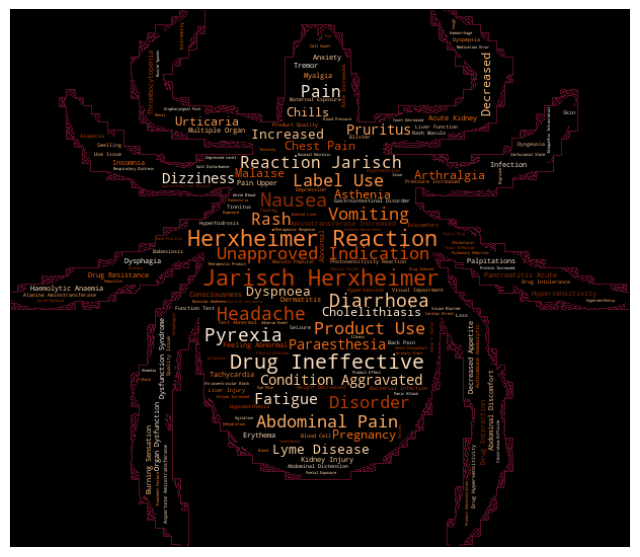

In [25]:
mask = np.array(Image.open('tickimage.jpeg'))

wc = WC(colormap="Oranges", background_color='black', contour_color='#5d0f24', contour_width=0.7, random_state=4, mask=mask, collocations=True).generate(swt)
plt.figure(figsize=(8,8))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.savefig("tick_wordcloud.svg", bbox_inches='tight')
plt.show()

### Other

In [26]:
# antibiotics
# illnesses
# total_antibiotic_cases
# total_antibiotic_cases_tick
# percent_hospitalized_overall
# percent_hospitalized_overall_tick
# per_disease_cases